# importieren wichtige Pakete

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 500)
# für Visualisierung
import matplotlib.pyplot as plt
#plt.rcParams.keys()
plt.rcParams['ytick.labelsize'] = "large"
plt.rcParams['xtick.labelsize'] = "large"
plt.rcParams['axes.labelsize'] = "large"
plt.rcParams['figure.titlesize'] = "x-large"

from tsfresh.feature_extraction import EfficientFCParameters, MinimalFCParameters
from tsfresh.utilities.dataframe_functions import make_forecasting_frame
from tsfresh import extract_features, select_features

import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm
import lightgbm as lgb

from sklearn.metrics import mean_squared_error
from math import sqrt

# Daten lesen und visualisieren

## load the data

In [2]:
# Eingabedateien haben keine Spaltennamen, hier die Namen der Spalte wird definiert
# Es enthält 26 Spalten: Motornummer, Zeitschritt, Drei betriebsbereite Sensoreinstellungen und 21 Sensormessungen.

# Motornummer, Zeitschritt
index_columns_names =  ["UnitNumber","Cycle"]
# 3 betriebsbereite Sensoreinstellungen
operational_settings_columns_names = ["Operation Setting "+str(i) for i in range(1,4)]
# 21 Sensormessungen
sensor_measure_columns_names =["Sensor Measure"+str(i) for i in range(1,22)]

input_file_column_names = index_columns_names + operational_settings_columns_names + sensor_measure_columns_names

In [3]:
# Laden die Daten FD001 als Beispiel
print("Laden der Daten beginnt!")
train_data = pd.read_csv('./data/train_FD001.txt', delim_whitespace=True, header=None)
train_data.columns = input_file_column_names
print("Laden der Daten ist fertig!")
print("Größe der Daten : Rows {}, Columns {}".format(train_data.shape[0], train_data.shape[1]))
train_data.head()

Laden der Daten beginnt!
Laden der Daten ist fertig!
Größe der Daten : Rows 20631, Columns 26


,UnitNumber,Cycle,Operation Setting 1,Operation Setting 2,Operation Setting 3,Sensor Measure1,Sensor Measure2,Sensor Measure3,Sensor Measure4,Sensor Measure5,Sensor Measure6,Sensor Measure7,Sensor Measure8,Sensor Measure9,Sensor Measure10,Sensor Measure11,Sensor Measure12,Sensor Measure13,Sensor Measure14,Sensor Measure15,Sensor Measure16,Sensor Measure17,Sensor Measure18,Sensor Measure19,Sensor Measure20,Sensor Measure21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


    Die obige Tabelle zeigt nur die ersten fünf Zeilen der Training Datensatz. Die erste Spalte ist die Motornummer und die zweite Spalte die Anzahl der Zyklen. Aus der Abbildung ist ersichtlich, dass sich der Sensor Information und die Arbeitsbedingungen sich in verschiedenen Zyklen geändert haben.

## RUL Berechnung
    Betreutes Lernen wird in der nächsten Analyse verwendet. Die Trainingsdaten enthalten jedoch keinen y-Wert (RUL). Hier lineare Degradationsmodell wird benutzt. Die Zeitschritt (Cycle) wird umgekehrt, wobei die verbleibende Zeit einer Maschine beim Ausfall 1 beträgt.

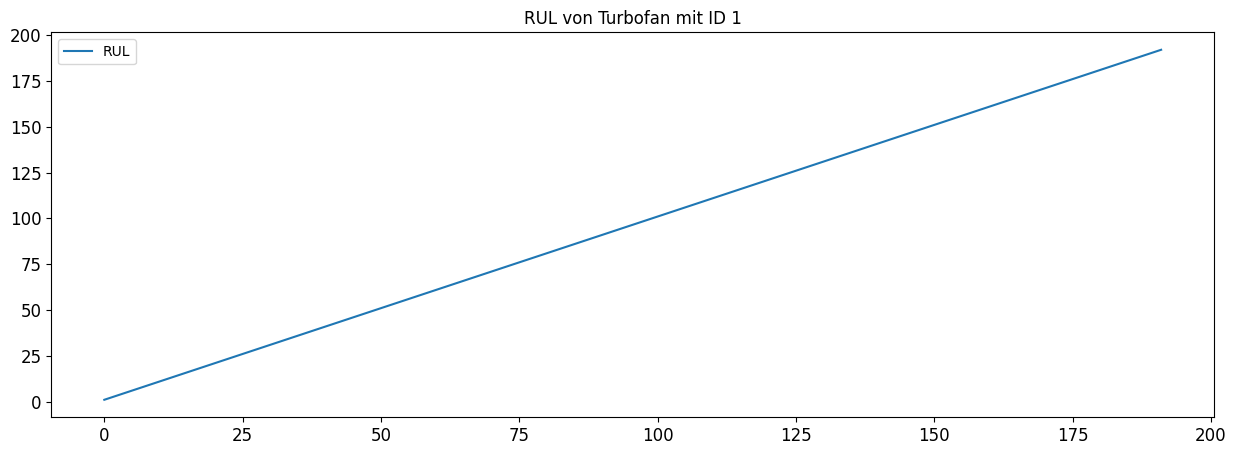

In [4]:

def f1(col):
    # Option 1: Reverse the time evolution, where remaining time of a machine is 1 at the failure.
    return col[::-1]  
train_data['rul'] = train_data[['UnitNumber', 'Cycle']].groupby('UnitNumber').transform(f1)
plt.figure(figsize=(15,5))
motor_id = 1
df_of_id = train_data[train_data["UnitNumber"]==motor_id]
plt.plot(df_of_id.rul, label="RUL")
#plt.plot(df_of_id.Cycle, label="Cycle")
plt.legend()
plt.title("RUL von Turbofan mit ID {}".format(motor_id))
plt.show()

# Datenanalyse-Pipeline

## Merkmale Entwicklung
       Bei der Merkmale Entwicklung wird versucht, die Vorhersageleistung der Lernalgorithmen durch Erstellen von Merkmalen aus Rohdaten zu verbessern und mit diesen den Lernprozess zu vereinfachen. Die neuen Features sollen zusätzliche Informationen bereitstellen, die in den ursprünglichen oder vorhandenen Featuregruppen nicht eindeutig erfasst werden können oder nicht einfach ersichtlich sind. Doch dieser Prozess nicht einfach. Fundierte und produktive Entscheidungen erfordern häufig ein gewisses Fachwissen.
       
      Wie in der folgenden Abbildung gezeigt, verwenden wir TSFRESH, um Zeitreihen-Features aus verschiedenen Domain automatisch zu extrahieren. (https://tsfresh.readthedocs.io/en/latest/index.html)

<img src=https://www.sdsc-bw.de/image/tsfresh.png  style="width: 600px;"/>

**Sliding Window Method**

    Sliding Window Method wird verwendet um die Eingabe und Ausgabe zum Koppeln.
    
    Nehmen wir an, Sie haben eine Sensor-Zeitreihe. Nun möchten Sie ein Merkmale-basiertes Modell erstellen, um die RUL vorherzusagen. Sie müssen also in jedem Zeitschritt der ursprünglichen Zeitreihe Merkmale extrahieren, während Sie eine bestimmte Anzahl vergangener Werte betrachten. Ein Rollmechanismus (Sliding Window Method) gibt Ihnen die Unterzeitserie der letzten k Zeitschritte zum Erstellen der Merkmale (Hier k ist Window Size).

    Das folgende Bild zeigt den Vorgang. Das rote Kästchen ist die entsprechende RUL für jedes Fenster. Die Merkmale Entwicklung wird in jedem Fenster durchgeführt.

<img src=https://www.sdsc-bw.de/image/rolling.PNG  style="width: 600px;"/>



Die nachstehende Schiebefenster-Methode erweist sich als zu ineffizient. Daher wird die Ausführung des folgenden Codes sehr lange dauern. Bitte schreiben Sie Ihre eigene, effizientere Gleitfenster-Methode.

In [15]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from tsfresh import extract_features
from tsfresh.feature_extraction import MinimalFCParameters

# Define the window size
window_size = 5

# Extract the unique engine IDs
engine_id = train_data["UnitNumber"].unique()
feature_x = pd.DataFrame()
RUL = pd.Series()


for index in tqdm(engine_id):
    data_frame = train_data[train_data["UnitNumber"] == index]
    
    # Create a rolling window for all sensor measurements at once
    df_shift = data_frame[sensor_measure_columns_names].rolling(window=window_size, center = True).agg({
        col: ['sum','median','mean','count',  'std', 'var','max', 'min', lambda x: np.max(np.abs(x)), lambda x: np.sqrt(np.mean(x**2))] for col in sensor_measure_columns_names
    }).dropna()

    # Rename columns
    df_shift.columns = ['_'.join(col).strip() for col in df_shift.columns.values]

    if df_shift.isna().sum().sum() > 0:
        raise ValueError("NaN values found in the rolling window data.")


    y = data_frame["rul"].iloc[window_size-1:-1]

    feature_x = pd.concat([feature_x, df_shift])
    RUL = pd.concat([RUL, y])

# Reset index of feature_x and RUL to match
feature_x.reset_index(drop=True, inplace=True)
RUL.reset_index(drop=True, inplace=True)


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [02:52<00:00,  1.73s/it]


In [16]:
feature_x

,Sensor Measure1_sum,Sensor Measure1_median,Sensor Measure1_mean,Sensor Measure1_count,Sensor Measure1_std,Sensor Measure1_var,Sensor Measure1_max,Sensor Measure1_min,Sensor Measure1_<lambda>,Sensor Measure1_<lambda>,Sensor Measure2_sum,Sensor Measure2_median,Sensor Measure2_mean,Sensor Measure2_count,Sensor Measure2_std,Sensor Measure2_var,Sensor Measure2_max,Sensor Measure2_min,Sensor Measure2_<lambda>,Sensor Measure2_<lambda>,Sensor Measure3_sum,Sensor Measure3_median,Sensor Measure3_mean,Sensor Measure3_count,Sensor Measure3_std,Sensor Measure3_var,Sensor Measure3_max,Sensor Measure3_min,Sensor Measure3_<lambda>,Sensor Measure3_<lambda>,Sensor Measure4_sum,Sensor Measure4_median,Sensor Measure4_mean,Sensor Measure4_count,Sensor Measure4_std,Sensor Measure4_var,Sensor Measure4_max,Sensor Measure4_min,Sensor Measure4_<lambda>,Sensor Measure4_<lambda>,Sensor Measure5_sum,Sensor Measure5_median,Sensor Measure5_mean,Sensor Measure5_count,Sensor Measure5_std,Sensor Measure5_var,Sensor Measure5_max,Sensor Measure5_min,Sensor Measure5_<lambda>,Sensor Measure5_<lambda>,Sensor Measure6_sum,Sensor Measure6_median,Sensor Measure6_mean,Sensor Measure6_count,Sensor Measure6_std,Sensor Measure6_var,Sensor Measure6_max,Sensor Measure6_min,Sensor Measure6_<lambda>,Sensor Measure6_<lambda>,Sensor Measure7_sum,Sensor Measure7_median,Sensor Measure7_mean,Sensor Measure7_count,Sensor Measure7_std,Sensor Measure7_var,Sensor Measure7_max,Sensor Measure7_min,Sensor Measure7_<lambda>,Sensor Measure7_<lambda>,Sensor Measure8_sum,Sensor Measure8_median,Sensor Measure8_mean,Sensor Measure8_count,Sensor Measure8_std,Sensor Measure8_var,Sensor Measure8_max,Sensor Measure8_min,Sensor Measure8_<lambda>,Sensor Measure8_<lambda>,Sensor Measure9_sum,Sensor Measure9_median,Sensor Measure9_mean,Sensor Measure9_count,Sensor Measure9_std,Sensor Measure9_var,Sensor Measure9_max,Sensor Measure9_min,Sensor Measure9_<lambda>,Sensor Measure9_<lambda>,Sensor Measure10_sum,Sensor Measure10_median,Sensor Measure10_mean,Sensor Measure10_count,Sensor Measure10_std,Sensor Measure10_var,Sensor Measure10_max,Sensor Measure10_min,Sensor Measure10_<lambda>,Sensor Measure10_<lambda>,Sensor Measure11_sum,Sensor Measure11_median,Sensor Measure11_mean,Sensor Measure11_count,Sensor Measure11_std,Sensor Measure11_var,Sensor Measure11_max,Sensor Measure11_min,Sensor Measure11_<lambda>,Sensor Measure11_<lambda>,Sensor Measure12_sum,Sensor Measure12_median,Sensor Measure12_mean,Sensor Measure12_count,Sensor Measure12_std,Sensor Measure12_var,Sensor Measure12_max,Sensor Measure12_min,Sensor Measure12_<lambda>,Sensor Measure12_<lambda>,Sensor Measure13_sum,Sensor Measure13_median,Sensor Measure13_mean,Sensor Measure13_count,Sensor Measure13_std,Sensor Measure13_var,Sensor Measure13_max,Sensor Measure13_min,Sensor Measure13_<lambda>,Sensor Measure13_<lambda>,Sensor Measure14_sum,Sensor Measure14_median,Sensor Measure14_mean,Sensor Measure14_count,Sensor Measure14_std,Sensor Measure14_var,Sensor Measure14_max,Sensor Measure14_min,Sensor Measure14_<lambda>,Sensor Measure14_<lambda>,Sensor Measure15_sum,Sensor Measure15_median,Sensor Measure15_mean,Sensor Measure15_count,Sensor Measure15_std,Sensor Measure15_var,Sensor Measure15_max,Sensor Measure15_min,Sensor Measure15_<lambda>,Sensor Measure15_<lambda>,Sensor Measure16_sum,Sensor Measure16_median,Sensor Measure16_mean,Sensor Measure16_count,Sensor Measure16_std,Sensor Measure16_var,Sensor Measure16_max,Sensor Measure16_min,Sensor Measure16_<lambda>,Sensor Measure16_<lambda>,Sensor Measure17_sum,Sensor Measure17_median,Sensor Measure17_mean,Sensor Measure17_count,Sensor Measure17_std,Sensor Measure17_var,Sensor Measure17_max,Sensor Measure17_min,Sensor Measure17_<lambda>,Sensor Measure17_<lambda>,Sensor Measure18_sum,Sensor Measure18_median,Sensor Measure18_mean,Sensor Measure18_count,Sensor Measure18_std,Sensor Measure18_var,Sensor Measure18_max,Sensor Measure18_min,Sensor Measure18_<lambda>,Sensor Measure18_<lambda>,Sensor Measure19_sum,

In [6]:
RUL

0          5.0
1          6.0
2          7.0
3          8.0
4          9.0
         ...  
20226    196.0
20227    197.0
20228    198.0
20229    199.0
20230    200.0
Length: 20231, dtype: float64